<a href="https://colab.research.google.com/github/Peter-obi/JAX/blob/main/First_NN_jax_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms

## Download the MNIST dataset

In [3]:
data_dir = '/tmps/tfds'
data_train = datasets.MNIST(root = data_dir, train = True, download = True, transform = transforms.ToTensor())
data_test = datasets.MNIST(root = data_dir, train = False, download = True, transform = transforms.ToTensor())

## Display the dataset

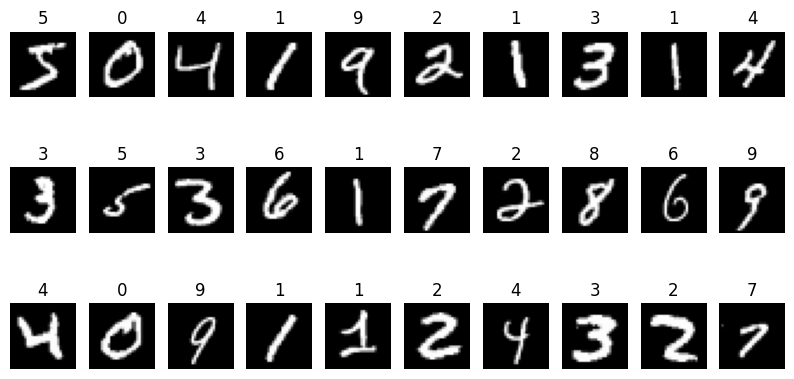

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10
i = 0

fig, ax = plt.subplots(ROWS, COLS)

for image, label in torch.utils.data.DataLoader(data_train, batch_size = 1):
  if i >= ROWS * COLS:
    break

  ax[int(i/COLS), i%COLS].axis('off')
  ax[int(i/COLS), i%COLS].set_title(str(label.item()))
  ax[int(i/COLS), i%COLS].imshow(image.squeeze().numpy(), cmap = 'gray')
  i += 1

plt.show()

## Get train and test data

In [5]:
HEIGHT = 28
WIDTH = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = len(data_train.classes)

train_data = torch.utils.data.DataLoader(data_train, batch_size = 32, shuffle = True, num_workers = 0)
test_data = torch.utils.data.DataLoader(data_test, batch_size = 32, shuffle = False, num_workers = 0)

## Initialize Neural network params

In [7]:
from jax import random

LAYER_SIZES = [HEIGHT * WIDTH, 512, 10]
PARAM_SCALE = 0.01

def init_network_params(sizes, key = random.PRNGKey(0), scale = 1e-2):
  """Initialize all layers for a fully-connected neural network with given sizes"""
  def random_layer_params(m, n, k, scale):
    """A helper function to randomly initialize weights and biases in a layer"""
    w_key, b_key = random.split(k)
    return scale * random.normal(w_key, (n,m)), scale * random.normal(b_key, (n,))

  keys = random.split(key, len(sizes) - 1)
  return [random_layer_params(m, n, k, scale)
  for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

params = init_network_params(LAYER_SIZES, random.PRNGKey(0), scale = PARAM_SCALE)

## Apply NN forward pass

In [11]:
import jax.numpy as jnp
from jax.nn import swish

def predict(params, image):
  """Function for per image predictions"""
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

## Generate random image and run the NN

In [12]:
random_flattened_image = random.normal(random.PRNGKey(1), (28*28*1,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


## Generate a batch of images

In [13]:
random_flattened_images = random.normal(random.PRNGKey(1), (32, 28*28*1))

## Vectorize forward pass for batch predictions

In [14]:
from jax import vmap
batched_predict = vmap(predict, in_axes = (None, 0))

## Run forward pass on a batch of images

In [15]:
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(32, 10)


## Create loss function and get the log probabilities for each class

In [20]:
from jax.nn import logsumexp
def loss(params, images, targets):
  """Categorical cross entropy loss function"""
  logits = batched_predict(params, images)
  log_preds = logits - logsumexp(logits)
  return -jnp.mean(targets * log_preds)

## Get value of the loss and the grads

In [22]:
from jax import value_and_grad
from jax import jit

INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

@jit
def update(params, x, y, epoch_number):
  loss_value, grads = value_and_grad(loss) (params, x, y)

  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return[(w -  lr * dw, b - lr * db)
          for (w, b), (dw, db) in zip(params, grads)], loss_value

## Training loop

In [21]:
from jax.nn import one_hot
import jax.numpy as jnp

num_epochs = 25

def batch_accuracy(parmas, images, targets):
  """Calculates accuracy (the percentage of correct answers) for a batch"""
  images = jnp.asarray(images) # Convert to JAX array
  targets = jnp.asarray(targets) # Convert to JAX array
  images = jnp.reshape(images, (len(images), NUM_PIXELS))
  predicted_class = jnp.argmax(batched_predict(params, images), axis = 1)
  return jnp.mean(predicted_class == targets)

def accuracy(params, data):
  """Calculates accuracy for a whole dataset with many batches"""
  accs = []
  for images, targets in data:
    accs.append(batch_accuracy(params, images, targets))
  return jnp.mean(jnp.array(accs))

import time

for epoch in range(num_epochs):
  start_time = time.time()
  losses = []
  for x, y in train_data:
    x = jnp.asarray(x) # Convert to JAX array
    y = jnp.asarray(y) # Convert to JAX array
    x = jnp.reshape(x, (len(x), NUM_PIXELS))
    y = one_hot(y, NUM_LABELS)
    params, loss_value = update(params, x, y, epoch)
    losses.append(loss_value)
  epoch_time = time.time() - start_time

  start_time = time.time()
  train_acc = accuracy(params, train_data)
  test_acc = accuracy(params, test_data)
  eval_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Eval in {:0.2f} sec".format(eval_time))
  print("Training set loss {}".format(jnp.mean(jnp.array(losses))))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 in 63.76 sec
Eval in 20.83 sec
Training set loss 0.4108935594558716
Training set accuracy 0.9271500110626221
Test set accuracy 0.928414523601532
Epoch 1 in 60.01 sec
Eval in 23.86 sec
Training set loss 0.37755098938941956
Training set accuracy 0.9496666789054871
Test set accuracy 0.9489815831184387
Epoch 2 in 63.94 sec
Eval in 20.53 sec
Training set loss 0.371034175157547
Training set accuracy 0.9588500261306763
Test set accuracy 0.9573681950569153
Epoch 3 in 79.47 sec
Eval in 25.02 sec
Training set loss 0.3675824999809265
Training set accuracy 0.9647499918937683
Test set accuracy 0.9606629014015198
Epoch 4 in 58.76 sec
Eval in 21.04 sec
Training set loss 0.36522960662841797
Training set accuracy 0.9699666500091553
Test set accuracy 0.9671525359153748
Epoch 5 in 60.21 sec
Eval in 21.10 sec
Training set loss 0.3635335862636566
Training set accuracy 0.9736999869346619
Test set accuracy 0.9692491888999939
Epoch 6 in 58.16 sec
Eval in 20.72 sec
Training set loss 0.3622332215309143


In [25]:
num_epochs = 25

@jit
def batch_accuracy(params, images, targets):
  """Calculates accuracy (the percentage of correct answers) for a batch"""
  images = jnp.reshape(images, (len(images), NUM_PIXELS))
  predicted_class = jnp.argmax(batched_predict(params, images), axis = 1)
  return jnp.mean(predicted_class == targets)

def accuracy(params, data):
  """Calculates accuracy for a whole dataset with many batches"""
  accs = []
  for images, targets in data:
    # Convert torch.Tensor to jnp.ndarray *before* passing to the jit-compiled function
    images_jax = jnp.asarray(images)
    targets_jax = jnp.asarray(targets)
    accs.append(batch_accuracy(params, images_jax, targets_jax))
  return jnp.mean(jnp.array(accs))

import time

for epoch in range(num_epochs):
  start_time = time.time()
  losses = []
  for x, y in train_data:
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    x = jnp.reshape(x, (len(x), NUM_PIXELS))
    y = one_hot(y, NUM_LABELS)
    params, loss_value = update(params, x, y, epoch)
    losses.append(loss_value)
  epoch_time = time.time() - start_time

  start_time = time.time()
  train_acc = accuracy(params, train_data)
  test_acc = accuracy(params, test_data)
  eval_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Eval in {:0.2f} sec".format(eval_time))
  print("Training set loss {}".format(jnp.mean(jnp.array(losses))))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 in 13.92 sec
Eval in 16.25 sec
Training set loss 0.35416993498802185
Training set accuracy 0.9922833442687988
Test set accuracy 0.9813298583030701


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 in 13.99 sec
Eval in 15.62 sec
Training set loss 0.3539513051509857
Training set accuracy 0.9932000041007996
Test set accuracy 0.9808306694030762
Epoch 2 in 13.71 sec
Eval in 15.46 sec
Training set loss 0.35371464490890503
Training set accuracy 0.9935833215713501
Test set accuracy 0.9819288849830627


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3 in 13.80 sec
Eval in 15.77 sec
Training set loss 0.3535102903842926
Training set accuracy 0.9939333200454712
Test set accuracy 0.9807308316230774
Epoch 4 in 14.09 sec
Eval in 15.61 sec
Training set loss 0.35331785678863525
Training set accuracy 0.9943833351135254
Test set accuracy 0.9815295338630676


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5 in 14.61 sec
Eval in 15.88 sec
Training set loss 0.35311949253082275
Training set accuracy 0.9948166608810425
Test set accuracy 0.9817292094230652
Epoch 6 in 13.79 sec
Eval in 15.65 sec
Training set loss 0.35295194387435913
Training set accuracy 0.9950833320617676
Test set accuracy 0.9823282361030579
Epoch 7 in 14.10 sec
Eval in 15.85 sec
Training set loss 0.3527994155883789
Training set accuracy 0.9949666857719421
Test set accuracy 0.9816293716430664


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8 in 13.85 sec
Eval in 15.70 sec
Training set loss 0.35263776779174805
Training set accuracy 0.9954500198364258
Test set accuracy 0.9824280738830566


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9 in 14.34 sec
Eval in 15.97 sec
Training set loss 0.3524956703186035
Training set accuracy 0.9953333735466003
Test set accuracy 0.9822283983230591
Epoch 10 in 13.79 sec
Eval in 15.53 sec
Training set loss 0.35237324237823486
Training set accuracy 0.9958000183105469
Test set accuracy 0.9821285605430603
Epoch 11 in 13.78 sec
Eval in 16.00 sec
Training set loss 0.3522228002548218
Training set accuracy 0.9962000250816345
Test set accuracy 0.9819288849830627
Epoch 12 in 13.77 sec
Eval in 15.50 sec
Training set loss 0.35210534930229187
Training set accuracy 0.9962500333786011
Test set accuracy 0.9814296960830688
Epoch 13 in 13.65 sec
Eval in 15.87 sec
Training set loss 0.3519633412361145
Training set accuracy 0.9965833425521851
Test set accuracy 0.9815295338630676
Epoch 14 in 13.80 sec
Eval in 15.59 sec
Training set loss 0.3518517017364502
Training set accuracy 0.9965833425521851
Test set accuracy 0.9825279116630554
Epoch 15 in 13.66 sec
Eval in 15.52 sec
Training set loss 0.351724952

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21 in 14.01 sec
Eval in 16.07 sec
Training set loss 0.3511243462562561
Training set accuracy 0.9976166486740112
Test set accuracy 0.9829273223876953


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22 in 14.09 sec
Eval in 16.35 sec
Training set loss 0.3510400056838989
Training set accuracy 0.9977166652679443
Test set accuracy 0.9827276468276978
Epoch 23 in 14.16 sec
Eval in 15.80 sec
Training set loss 0.35095760226249695
Training set accuracy 0.9976666569709778
Test set accuracy 0.9829273223876953
Epoch 24 in 14.12 sec
Eval in 16.48 sec
Training set loss 0.350868284702301
Training set accuracy 0.99795001745224
Test set accuracy 0.9826277494430542


In [26]:
import pickle
model_weights_file = 'mlp_weights.pickle'
with open(model_weights_file, 'wb') as file:
  pickle.dump(params, file)
with open(model_weights_file, 'rb') as file:
  restored_params = pickle.load(file)